#Import libraries

In [1]:
import numpy as np
import math
from numba import cuda, jit, prange, float32
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import time

#Kernels

##RGB to HSV

In [2]:
@cuda.jit
def rgb2hsv_kernel(rgb_image, H, S, V):
    height, width, _ = rgb_image.shape
    x, y = cuda.grid(2)

    if x < height and y < width:
        # Scale R, G, B to [0..1]
        r = rgb_image[x, y, 0] / 255.0
        g = rgb_image[x, y, 1] / 255.0
        b = rgb_image[x, y, 2] / 255.0

        rgb_max = max(r, g, b)
        rgb_min = min(r, g, b)
        delta = rgb_max - rgb_min

        # Value
        V[x, y] = rgb_max

        # Saturation
        if rgb_max == 0:
            S[x, y] = 0
        else:
            S[x, y] = delta / rgb_max

        # Hue
        if delta == 0:
            H[x, y] = 0
        elif rgb_max == r:
            H[x, y] = (60 * ((g - b) / delta) + 360) % 360
        elif rgb_max == g:
            H[x, y] = (60 * ((b - r) / delta) + 120) % 360
        elif rgb_max == b:
            H[x, y] = (60 * ((r - g) / delta) + 240) % 360

##HSV to RGB

In [3]:
@cuda.jit
def hsv2rgb_kernel(H, S, V, rgb_image):
    height, width = H.shape
    x, y = cuda.grid(2)

    if x < height and y < width:
        h = H[x, y]
        s = S[x, y]
        v = V[x, y]

        if s == 0:
            rgb_image[x, y, 0] = rgb_image[x, y, 1] = rgb_image[x, y, 2] = int(v * 255)
        else:
            d = h / 60
            hi = int(d) % 6
            f = d - hi
            l = v * (1 - s)
            m = v * (1 - f * s)
            n = v * (1 - (1 - f) * s)

            if hi == 0:
                rgb_image[x, y, 0] = int(v * 255)
                rgb_image[x, y, 1] = int(n * 255)
                rgb_image[x, y, 2] = int(l * 255)
            elif hi == 1:
                rgb_image[x, y, 0] = int(m * 255)
                rgb_image[x, y, 1] = int(v * 255)
                rgb_image[x, y, 2] = int(l * 255)
            elif hi == 2:
                rgb_image[x, y, 0] = int(l * 255)
                rgb_image[x, y, 1] = int(v * 255)
                rgb_image[x, y, 2] = int(n * 255)
            elif hi == 3:
                rgb_image[x, y, 0] = int(l * 255)
                rgb_image[x, y, 1] = int(m * 255)
                rgb_image[x, y, 2] = int(v * 255)
            elif hi == 4:
                rgb_image[x, y, 0] = int(n * 255)
                rgb_image[x, y, 1] = int(l * 255)
                rgb_image[x, y, 2] = int(v * 255)
            elif hi == 5:
                rgb_image[x, y, 0] = int(v * 255)
                rgb_image[x, y, 1] = int(l * 255)
                rgb_image[x, y, 2] = int(m * 255)

##Kuwahara filter

In [4]:
@cuda.jit
def kuwahara_kernel(rgb_image, H, S, V, output_rgb, window_size, use_shared_memory):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    block_width = cuda.blockDim.x
    block_height = cuda.blockDim.y

    x = bx * block_width + tx
    y = by * block_height + ty

    height, width, _ = rgb_image.shape

    actual_window_size = window_size + 1

    if use_shared_memory:
        shared_size_x = block_width + 2 * window_size
        shared_size_y = block_height + 2 * window_size

        shared_H = cuda.shared.array(shape=(32+2*5, 32+2*5), dtype=np.float32)
        shared_S = cuda.shared.array(shape=(32+2*5, 32+2*5), dtype=np.float32)
        shared_V = cuda.shared.array(shape=(32+2*5, 32+2*5), dtype=np.float32)
        shared_R = cuda.shared.array(shape=(32+2*5, 32+2*5), dtype=np.float32)
        shared_G = cuda.shared.array(shape=(32+2*5, 32+2*5), dtype=np.float32)
        shared_B = cuda.shared.array(shape=(32+2*5, 32+2*5), dtype=np.float32)

        # Load data into shared memory
        for dy in range(0, shared_size_y, block_height):
            for dx in range(0, shared_size_x, block_width):
                shared_y = ty + dy
                shared_x = tx + dx
                global_y = y - window_size + dy
                global_x = x - window_size + dx

                if (global_y >= 0 and global_y < height and
                    global_x >= 0 and global_x < width):
                    shared_H[shared_y, shared_x] = H[global_y, global_x]
                    shared_S[shared_y, shared_x] = S[global_y, global_x]
                    shared_V[shared_y, shared_x] = V[global_y, global_x]
                    shared_R[shared_y, shared_x] = rgb_image[global_y, global_x, 0]
                    shared_G[shared_y, shared_x] = rgb_image[global_y, global_x, 1]
                    shared_B[shared_y, shared_x] = rgb_image[global_y, global_x, 2]
                else:
                    shared_H[shared_y, shared_x] = 0.0
                    shared_S[shared_y, shared_x] = 0.0
                    shared_V[shared_y, shared_x] = 0.0
                    shared_R[shared_y, shared_x] = 0.0
                    shared_G[shared_y, shared_x] = 0.0
                    shared_B[shared_y, shared_x] = 0.0

        cuda.syncthreads()

    if x < width and y < height:
        means = cuda.local.array((4, 3), dtype=np.float32)  # [window][R,G,B]
        variances = cuda.local.array(4, dtype=np.float32)

        for k in range(4):
            sum_R = 0.0
            sum_G = 0.0
            sum_B = 0.0
            sum_V = 0.0
            sum_sq_V = 0.0
            count = 0

            if use_shared_memory:
                shared_x = tx + window_size
                shared_y = ty + window_size

                if k == 0:    # W1: Top-left
                    y_start, y_end = shared_y - window_size, shared_y + 1
                    x_start, x_end = shared_x - window_size, shared_x + 1
                elif k == 1:  # W2: Top-right
                    y_start, y_end = shared_y - window_size, shared_y + 1
                    x_start, x_end = shared_x, shared_x + window_size + 1
                elif k == 2:  # W3: Bottom-left
                    y_start, y_end = shared_y, shared_y + window_size + 1
                    x_start, x_end = shared_x - window_size, shared_x + 1
                else:         # W4: Bottom-right
                    y_start, y_end = shared_y, shared_y + window_size + 1
                    x_start, x_end = shared_x, shared_x + window_size + 1
            else:
                if k == 0:    # W1: Top-left
                    y_start, y_end = max(0, y - window_size), y + 1
                    x_start, x_end = max(0, x - window_size), x + 1
                elif k == 1:  # W2: Top-right
                    y_start, y_end = max(0, y - window_size), y + 1
                    x_start, x_end = x, min(width, x + window_size + 1)
                elif k == 2:  # W3: Bottom-left
                    y_start, y_end = y, min(height, y + window_size + 1)
                    x_start, x_end = max(0, x - window_size), x + 1
                else:         # W4: Bottom-right
                    y_start, y_end = y, min(height, y + window_size + 1)
                    x_start, x_end = x, min(width, x + window_size + 1)

            for yi in range(y_start, y_end):
                for xi in range(x_start, x_end):
                    count += 1
                    if use_shared_memory:
                        r = shared_R[yi, xi]
                        g = shared_G[yi, xi]
                        b = shared_B[yi, xi]
                        v = shared_V[yi, xi]
                    else:
                        r, g, b = rgb_image[yi, xi]
                        v = V[yi, xi]

                    sum_R += r
                    sum_G += g
                    sum_B += b
                    sum_V += v
                    sum_sq_V += v * v

            if count > 0:
                means[k, 0] = sum_R / count
                means[k, 1] = sum_G / count
                means[k, 2] = sum_B / count
                mean_V = sum_V / count
                variances[k] = (sum_sq_V / count) - (mean_V * mean_V)
            else:
                variances[k] = 1e10

        min_var = variances[0]
        min_idx = 0
        for k in range(1, 4):
            if variances[k] < min_var:
                min_var = variances[k]
                min_idx = k

        output_rgb[y, x, 0] = means[min_idx, 0]
        output_rgb[y, x, 1] = means[min_idx, 1]
        output_rgb[y, x, 2] = means[min_idx, 2]

#Behaviors

##RGB to HSV conversion

In [5]:
def rgb2hsv(rgb_image):
    height, width, _ = rgb_image.shape
    H = np.zeros((height, width), dtype=np.float32)
    S = np.zeros((height, width), dtype=np.float32)
    V = np.zeros((height, width), dtype=np.float32)

    # Allocate device arrays
    d_rgb_image = cuda.to_device(rgb_image)
    d_H = cuda.to_device(H)
    d_S = cuda.to_device(S)
    d_V = cuda.to_device(V)

    # Define the grid and block sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = (height + (threads_per_block[0] - 1)) // threads_per_block[0]
    blocks_per_grid_y = (width + (threads_per_block[1] - 1)) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch the kernel
    rgb2hsv_kernel[blocks_per_grid, threads_per_block](d_rgb_image, d_H, d_S, d_V)

    # Copy the results back to the host
    H = d_H.copy_to_host()
    S = d_S.copy_to_host()
    V = d_V.copy_to_host()

    return H, S, V

##HSV to RGB conversion

In [6]:
def hsv2rgb(H, S, V):
    height, width = H.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Allocate device arrays
    d_H = cuda.to_device(H)
    d_S = cuda.to_device(S)
    d_V = cuda.to_device(V)
    d_rgb_image = cuda.to_device(rgb_image)

    # Define the grid and block sizes
    threads_per_block = (16, 16)
    blocks_per_grid_x = (height + (threads_per_block[0] - 1)) // threads_per_block[0]
    blocks_per_grid_y = (width + (threads_per_block[1] - 1)) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Launch the kernel
    hsv2rgb_kernel[blocks_per_grid, threads_per_block](d_H, d_S, d_V, d_rgb_image)

    # Copy the results back to the host
    rgb_image = d_rgb_image.copy_to_host()

    return rgb_image

##Kuwahara filter application

In [7]:
def apply_kuwahara_filter(image, window_size=5, use_shared_memory=False):
    # Convert RGB to HSV using your function (SCATTER)
    H, S, V = rgb2hsv(image)
     # Create output array
    output_rgb = np.zeros_like(image)

    # Set up grid and block dimensions
    threads_per_block = (16, 16)
    blocks_per_grid_x = math.ceil(image.shape[1] / threads_per_block[0])
    blocks_per_grid_y = math.ceil(image.shape[0] / threads_per_block[1])
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    # Apply Kuwahara filter
    kuwahara_kernel[blocks_per_grid, threads_per_block](
        image, H, S, V, output_rgb, window_size, use_shared_memory
    )

    return output_rgb

#Application

##Runner

In [8]:
def run_kuwahara_filter(original_image, window_size, shared_memory=False):
    # Create a writable copy of the image
    image = np.asarray(original_image, dtype=np.float32).copy()

    # Get image's resolution
    height, width = image.shape[:2]

    start_time = time.time()
    # Apply the Kuwahara filter to the image
    filtered_image = apply_kuwahara_filter(image, window_size, use_shared_memory=shared_memory)
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print("The Kuwahara filter took {:.2f} seconds to run.".format(elapsed_time))

    # Calculate the differences between the original and filtered images
    differences = np.abs(image.astype(np.float32) - filtered_image.astype(np.float32))

    percentage_difference = (differences / 255.0) * 100               # percentage of difference for each pixel
    overall_percentage_difference = np.mean(percentage_difference)    # overall percentage difference

    print("The filtered image has {:.2f}% difference compared to the original image.".format(overall_percentage_difference))

    # Display the original and filtered images
    print()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image.astype(np.uint8))
    axes[0].set_title('Original Image\nResolution: {} x {}'.format(width, height))
    axes[0].axis('off')

    axes[1].imshow(filtered_image.astype(np.uint8))
    axes[1].set_title('Filtered Image\nResolution: {} x {}'.format(width, height))
    axes[1].axis('off')

    plt.show()

##Load images

In [10]:
# Load images
img1 = plt.imread('/content/wolf1.jpg')
img2 = plt.imread('/content/wolf2.jpg')
img3 = plt.imread('/content/flower1.jpg')
img4 = plt.imread('/content/flower11.jpg')
img5 = plt.imread('/content/flower2.jpg')
img6 = plt.imread('/content/flower21.jpg')
img7 = plt.imread('/content/fantasy1.jpg')
img8 = plt.imread('/content/fantasy2.jpg')

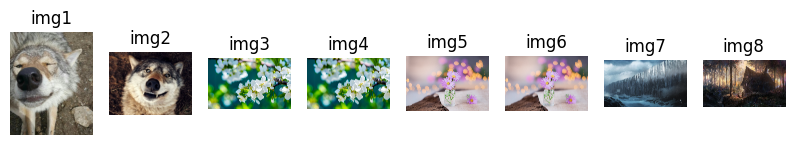

In [11]:
# Display the original image
plt.figure(figsize=(10, 5))

imgs = [img1, img2, img3, img4, img5, img6, img7, img8]

for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(img)
    plt.title(f'img{i + 1}')
    plt.axis('off')

plt.show()

##Apply filter

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 0.04 seconds to run.
The filtered image has 5.47% difference compared to the original image.



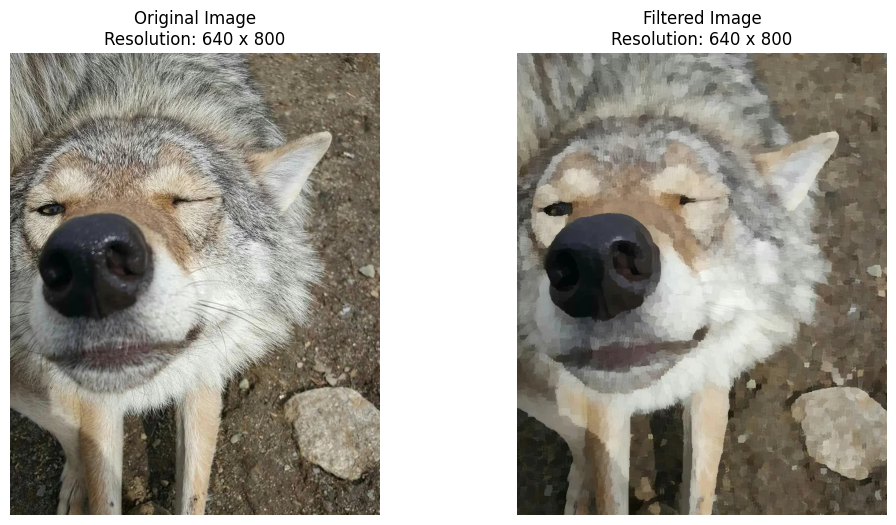



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 0.05 seconds to run.
The filtered image has 5.49% difference compared to the original image.



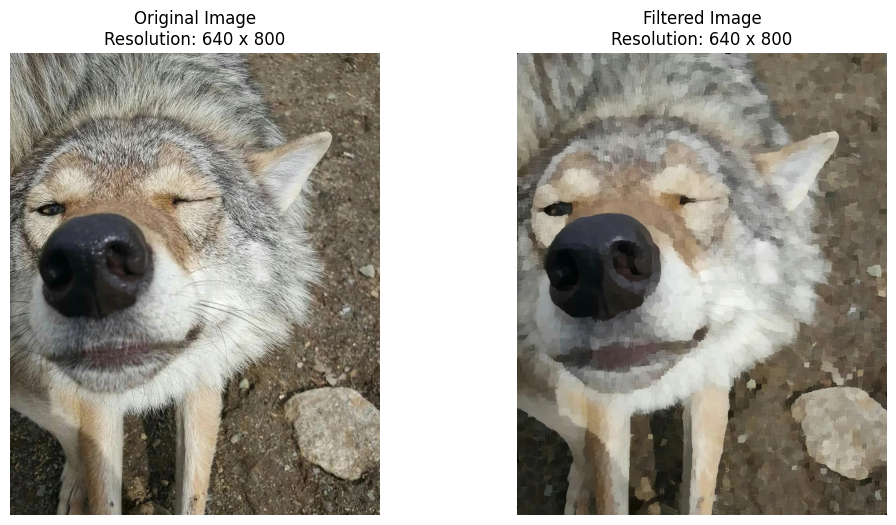

In [14]:
IMAGE = img1

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 0.04 seconds to run.
The filtered image has 3.87% difference compared to the original image.



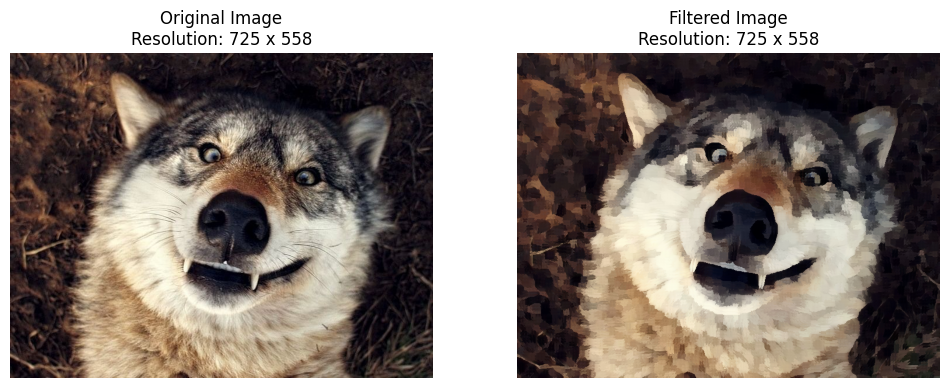



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 0.05 seconds to run.
The filtered image has 3.90% difference compared to the original image.



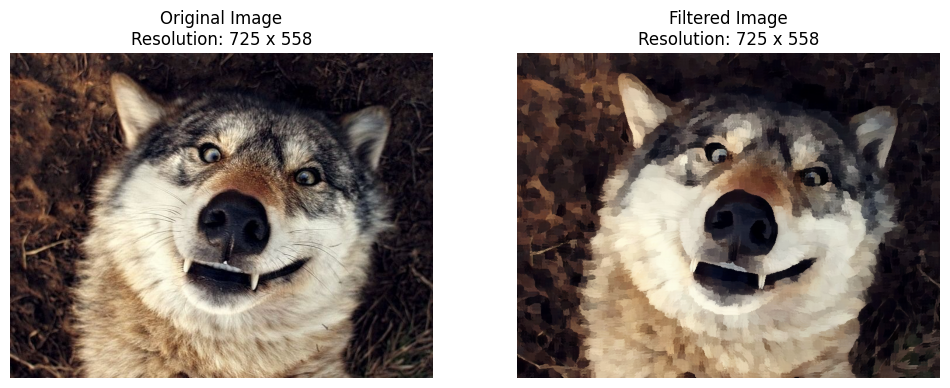

In [15]:
IMAGE = img2

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 0.28 seconds to run.
The filtered image has 1.49% difference compared to the original image.



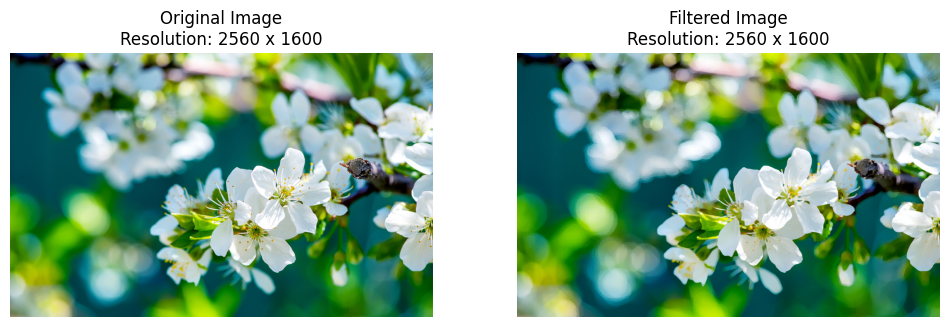



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 0.27 seconds to run.
The filtered image has 1.49% difference compared to the original image.



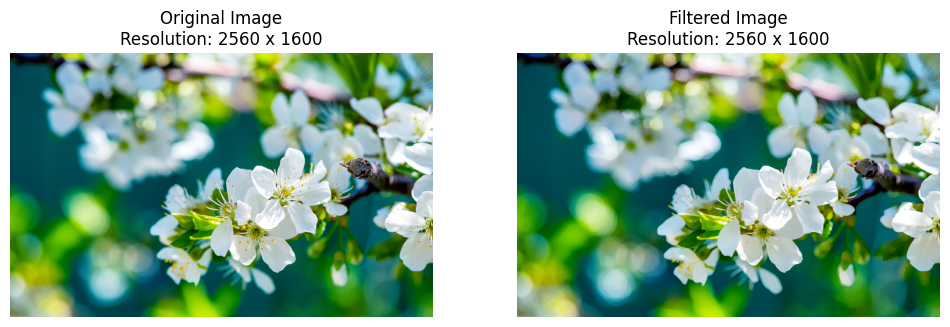

In [16]:
IMAGE = img3

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 2.48 seconds to run.
The filtered image has 0.55% difference compared to the original image.



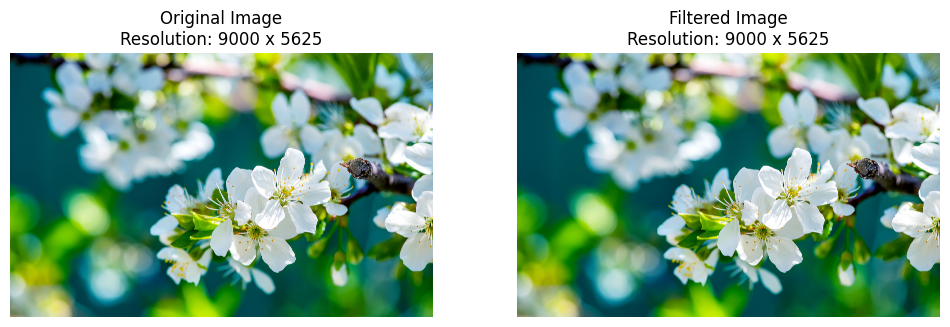



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 2.46 seconds to run.
The filtered image has 0.55% difference compared to the original image.



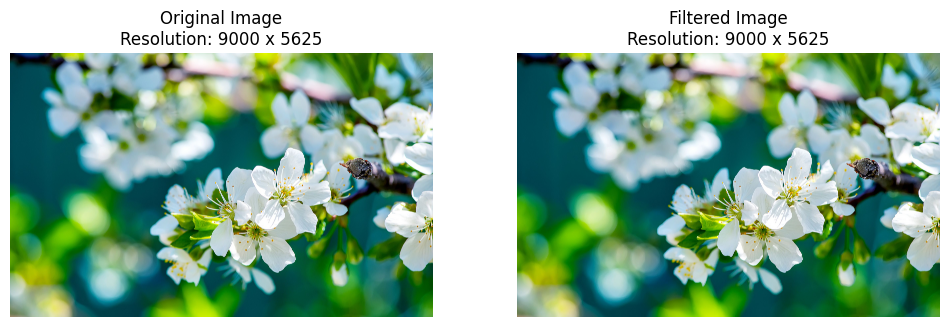

In [17]:
IMAGE = img4

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 0.59 seconds to run.
The filtered image has 1.06% difference compared to the original image.



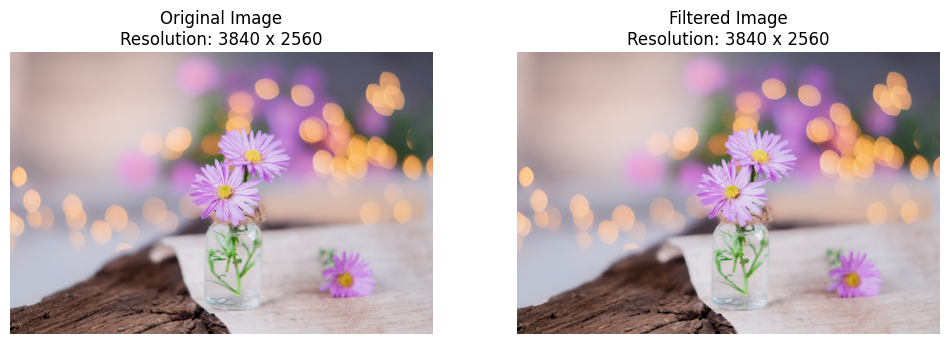



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 0.63 seconds to run.
The filtered image has 1.07% difference compared to the original image.



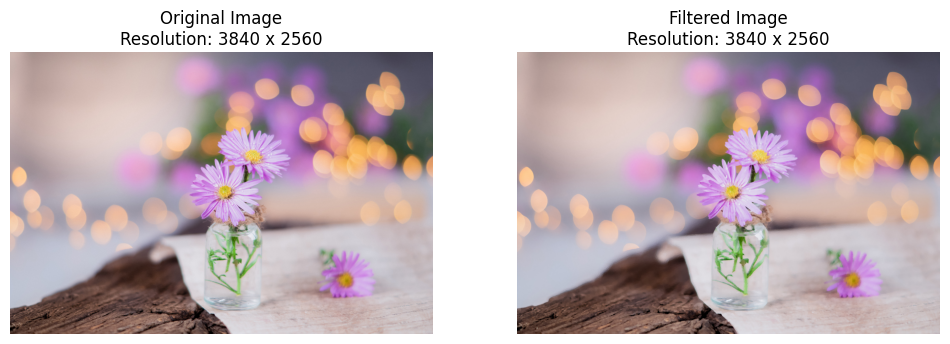

In [18]:
IMAGE = img5

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 2.67 seconds to run.
The filtered image has 0.66% difference compared to the original image.



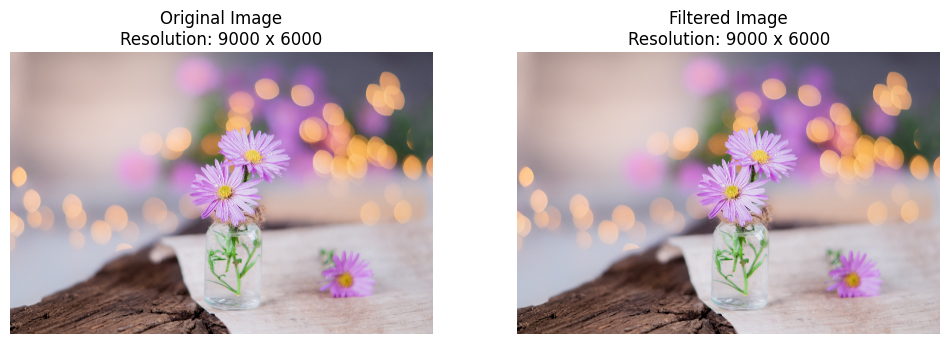



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 2.61 seconds to run.
The filtered image has 0.66% difference compared to the original image.



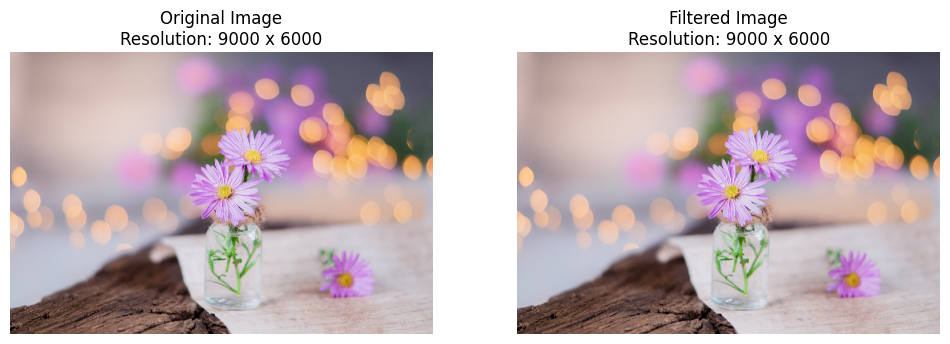

In [19]:
IMAGE = img6

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 0.87 seconds to run.
The filtered image has 0.61% difference compared to the original image.



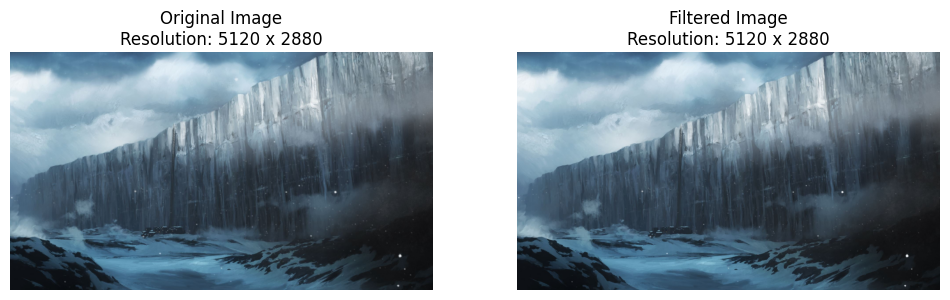



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 0.86 seconds to run.
The filtered image has 0.61% difference compared to the original image.



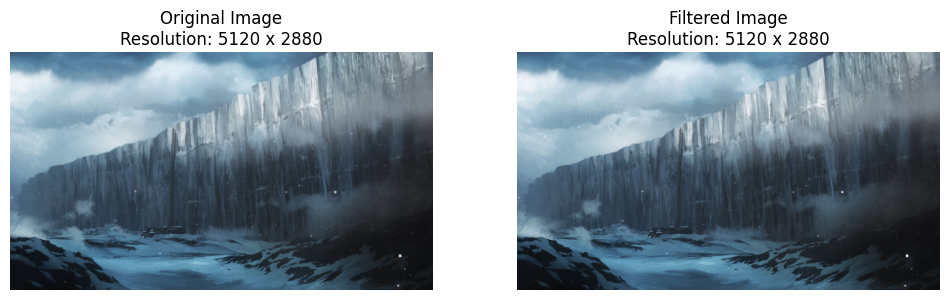

In [20]:
IMAGE = img7

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)

######################
- Kuwahara filter WITHOUT shared memory: 

The Kuwahara filter took 0.88 seconds to run.
The filtered image has 1.27% difference compared to the original image.



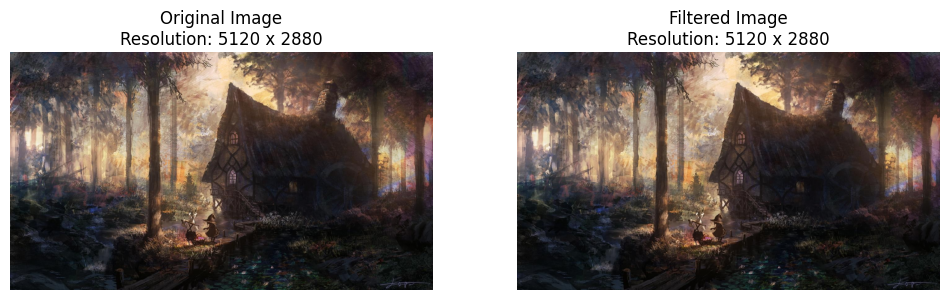



######################
- Kuwahara filter WITH shared memory: 

The Kuwahara filter took 0.83 seconds to run.
The filtered image has 1.28% difference compared to the original image.



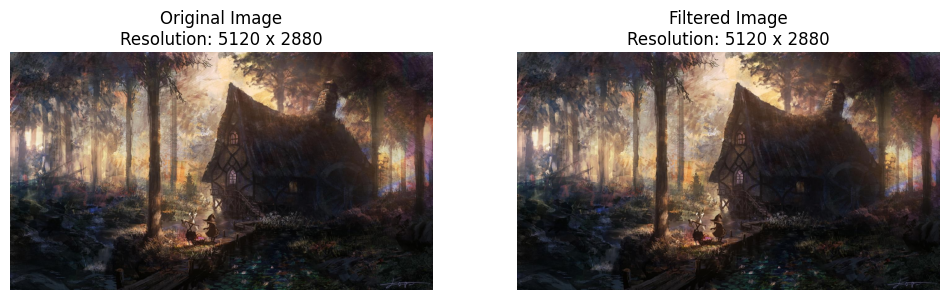

In [21]:
IMAGE = img8

print("######################")
print("- Kuwahara filter WITHOUT shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=False)

print()
print()
print("######################")
print("- Kuwahara filter WITH shared memory: \n")
run_kuwahara_filter(IMAGE, window_size=5, shared_memory=True)